# 🧪 Custom Gradient Boosting Regression

In this notebook, we implement gradient boosting on decision trees **from scratch**. We then compare the performance of these implementations with **scikit-learn**'s `GradientBoostingClassifier` and `DecisionTreeClassifier` models.

### ⚙️ Importing Libraries & Environment Setup

In [20]:
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.random import Generator as RandomGenerator
from numpy.typing import NDArray
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [21]:
%matplotlib inline

pd.set_option("display.width", 150)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

### 🧰 Utility Functions

In [22]:
def evaluate_regression_models(
    predictions: dict[str, NDArray[np.float64]], y: NDArray[np.float64]
) -> pd.DataFrame:
    """Evaluate multiple regression model predictions on the given dataset.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary where keys are
            model names and values are predicted target arrays corresponding to X.
        y (NDArray[np.float64]): True target values of shape (n_samples,).

    Returns:
        pd.DataFrame: DataFrame with evaluation metrics (MAE, MSE, R2) for each model.
            Columns correspond to model names; rows correspond to metrics.
    """
    evaluations = pd.DataFrame(columns=predictions.keys(), index=["MAE", "MSE", "R2"])

    for name, y_pred in predictions.items():
        mae = mean_absolute_error(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)

        evaluations.loc[:, name] = [mae, mse, r2]

    return evaluations.astype(float)

In [23]:
def plot_regression_models(
    predictions: dict[str, NDArray[np.float64]],
    X: NDArray[np.float64],
    y: NDArray[np.float64],
    X_test: NDArray[np.float64],
) -> None:
    """Plot regression results for multiple models on scatter data.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary mapping model names
            to predicted values for X_test.
        X (NDArray[np.float64]): Original feature data of shape (n_samples, 1)
            for scatter plot.
        y (NDArray[np.float64]): True target values corresponding to X.
        X_test (NDArray[np.float64]): Feature values where predictions are
            evaluated and plotted.
    """
    sns.scatterplot(x=X.flatten(), y=y.flatten(), alpha=0.3, label="Noisy data points")

    palette = sns.color_palette("Set1")
    for index, (name, y_pred) in enumerate(predictions.items()):
        sns.lineplot(
            x=X_test.flatten(),
            y=y_pred.flatten(),
            alpha=0.6,
            color=palette[index],
            label=name,
        )

    plt.xlabel("Feature")
    plt.ylabel("Target")
    plt.legend()
    plt.tight_layout()
    plt.show()

### 📥 Loading the Dataset

In [24]:
# Generate dataset
X, y = make_regression(
    n_samples=100, n_features=1, noise=10, bias=37.0, random_state=42
)

In [25]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 🧠 Implementing Custom Model Algorithms

In [26]:
class MyGBDTRegressor:
    """Gradient Boosted Decision Tree (GBDT) Regressor.

    This model builds an ensemble of decision trees sequentially, where each new tree
    is trained to predict the residuals (negative gradients) of the previous
    predictions. The final prediction is the sum of the initial prediction and the
    weighted predictions of all subsequent trees. Supports several tree parameters
    and learning rate control.

    Attributes:
        learning_rate (float): Shrinkage factor applied to each tree's contribution.
        n_estimators (int): Number of boosting iterations (trees).
        criterion (str): Function to measure split quality
            ("squared_error", "friedman_mse", "absolute_error", "poisson").
        splitter (str): Strategy used to choose the split at each node: "best"
            or "random".
        max_depth (int | None): Maximum depth allowed for each tree.
        min_samples_split (int | float): Minimum samples required to split an
            internal node.
        min_samples_leaf (int | float): Minimum samples required to be present at
            a leaf node.
        min_weight_fraction_leaf (float): Minimum fraction of samples required at
            a leaf node.
        max_features (int | float | str | None): Number or method of feature
            selection per split ("auto", "sqrt", "log2", or None).
        max_leaf_nodes (int | None): Maximum number of leaf nodes per tree.
        min_impurity_decrease (float): Minimum impurity decrease required
            to make a split.
        bootstrap (bool): Whether samples are drawn with replacement.
        ccp_alpha (float): Complexity parameter used for Minimal Cost-Complexity
            Pruning.
        rng (np.random.Generator): Random number generator instance.
        trees (list[MyDecisionTreeRegressor]): List of fitted regression trees.
        F0 (float | None): Initial prediction log-odds before any boosting.
    """

    def __init__(
        self,
        learning_rate: float,
        n_estimators: int,
        criterion: Literal[
            "squared_error", "friedman_mse", "absolute_error", "poisson"
        ] = "squared_error",
        splitter: Literal["best", "random"] = "best",
        max_depth: int | None = None,
        min_samples_split: int | float = 2,
        min_samples_leaf: int | float = 1,
        min_weight_fraction_leaf: float = 0.0,
        max_features: int | float | Literal["auto", "sqrt", "log2"] | None = None,
        max_leaf_nodes: int | None = None,
        min_impurity_decrease: float = 0.0,
        bootstrap: bool = True,
        random_state: int | None = None,
        ccp_alpha: float = 0.0,
    ) -> None:
        """Initialize the Random Forest regressor with hyperparameters.

        Args:
            learning_rate (float): Step size shrinkage applied to each tree's output.
            n_estimators (int): Number of trees in the forest.
            criterion (str): Function to measure split quality
                ("squared_error", "friedman_mse", "absolute_error", "poisson").
            splitter (str): Strategy used to choose the split at each node:
                "best" or "random".
            max_depth (int | None): Maximum depth of each tree.
            min_samples_split (int | float): Minimum samples needed to split a node.
            min_samples_leaf (int | float): Minimum samples needed in a leaf node.
            min_weight_fraction_leaf (float): Minimum weighted fraction needed in a
                leaf.
            max_features (int | float | str | None): Number or method of feature
                selection per split ("auto", "sqrt", "log2", or None).
            max_leaf_nodes (int | None): Maximum number of leaf nodes per tree.
            min_impurity_decrease (float): Threshold for impurity reduction to
                split nodes.
            bootstrap (bool): Whether to use bootstrap sampling.
            random_state (int | None): Seed for reproducibility.
            ccp_alpha (float): Complexity parameter for pruning.
        """
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.splitter = splitter
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.bootstrap = bootstrap
        self.ccp_alpha = ccp_alpha

        self.rng: RandomGenerator = np.random.default_rng(random_state)
        self.trees: list[DecisionTreeClassifier] = []
        self.F0: DecisionTreeClassifier | None = None

    def _compute_initial_value(self, y: NDArray[np.float64]) -> float:
        """Compute the initial prediction (mean of target values).

        Args:
            y (NDArray[np.float64]): Target values.

        Returns:
            float: Initial prediction (mean of y).
        """
        return np.mean(y)

    def _compute_gradient(
        self, y_true: NDArray[np.int64], y_pred: NDArray[np.int64]
    ) -> NDArray[np.float64]:
        """Compute residuals (negative gradient of squared error loss).

        Args:
            y_true (NDArray[np.float64]): True target values.
            y_pred (NDArray[np.float64]): Current model predictions.

        Returns:
            NDArray[np.float64]: Residuals to be fitted by the next tree.
        """
        return y_true - y_pred

    def fit(self, X: NDArray[np.float64], y: NDArray[np.float64]) -> None:
        """Fit the Gradient Boosted Decision Tree regressor to training data.

        Args:
            X (NDArray[np.float64]): Training data of shape (n_samples, n_features).
            y (NDArray[np.float64]): Target labels of shape (n_samples,).
        """
        self.F0 = self._compute_initial_value(y)
        Fm = np.full_like(y, self.F0, dtype=np.float64)
        self.trees.clear()

        for _ in range(self.n_estimators):
            residuals = self._compute_gradient(y, Fm)

            tree = DecisionTreeRegressor(
                criterion=self.criterion,
                splitter=self.splitter,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                min_weight_fraction_leaf=self.min_weight_fraction_leaf,
                max_features=self.max_features,
                max_leaf_nodes=self.max_leaf_nodes,
                min_impurity_decrease=self.min_impurity_decrease,
                ccp_alpha=self.ccp_alpha,
                random_state=self.rng.integers(1_000_000),
            )
            tree.fit(X, residuals)
            self.trees.append(tree)

            Fm += self.learning_rate * tree.predict(X)

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """Predict target values for samples in X.

        Args:
            X (NDArray[np.float64]): Input data of shape (n_samples, n_features).

        Returns:
            NDArray[np.float64]: Predicted values.
        """
        Fm = np.full(X.shape[0], self.F0, dtype=np.float64)
        for tree in self.trees:
            Fm += self.learning_rate * tree.predict(X)
        return Fm

### 🏋️‍♂️ Model Training

In [27]:
# Scikit-learn linear regression model
sklearn_linear_model = LinearRegression()
sklearn_linear_model.fit(X_train, y_train)

# Scikit-learn gradient boosting regressor model
sklearn_model = GradientBoostingRegressor(
    learning_rate=0.1, n_estimators=20, max_depth=2, random_state=42
)
sklearn_model.fit(X_train, y_train)

# My gradient boosting regressor model
my_model = MyGBDTRegressor(
    learning_rate=0.1, n_estimators=20, max_depth=2, random_state=42
)
my_model.fit(X_train, y_train)

### 📊 Comparing Algorithm Versions

In [28]:
predictions = {
    "scikit-learn_linear": sklearn_linear_model.predict(X_test),
    "scikit-learn": sklearn_model.predict(X_test),
    "my": my_model.predict(X_test),
}

In [29]:
evaluate_regression_models(predictions, y_test)

,scikit-learn_linear,scikit-learn,my
MAE,8.416660,9.672940,9.672940
MSE,104.202227,153.486568,153.486568
R2,0.937415,0.907815,0.907815


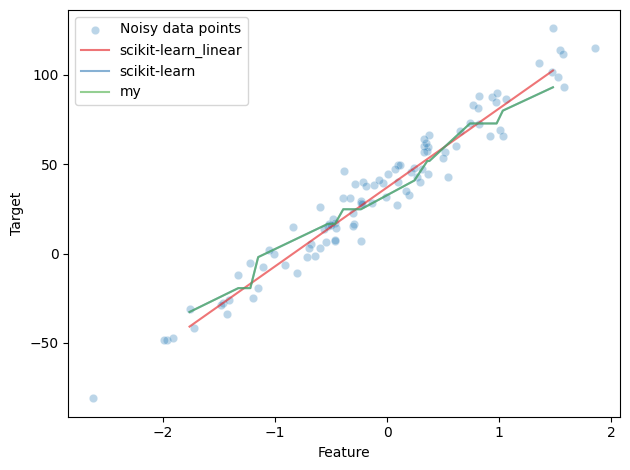

In [30]:
plot_regression_models(predictions, X, y, X_test)